## Ilias Tsachtsarlis - Part 2 of Data Manipulation

In [1]:
import pandas as pd
import numpy as np

Data downloaded from BigQuery where SQL statements performed in a Json format type document in order to prevent the rows threshold due to csv exporting limitation.

This file then got imported through Python having the help of Pandas library:

In [2]:
bi_df = pd.read_json('bq-results-20210618-000932-nxs5qoimyp6u.json', lines=True)
print(bi_df.shape)
bi_df.head(5)

(400000, 8)


,order_id,brand,submit_dt,user_id,shop_id,city,cuisine_parent,basket
0,2846837765,GR-EFOOD,2021-01-13 20:37:06 UTC,99103596,206490318,Βόλος,Healthy / Other,9.0
1,2878146359,GR-EFOOD,2021-01-22 14:28:57 UTC,77179398,206490318,Βόλος,Healthy / Other,7.0
2,2904155390,GR-EFOOD,2021-01-29 13:52:24 UTC,7233822,206490318,Βόλος,Healthy / Other,6.3
3,2867086278,GR-EFOOD,2021-01-19 12:19:59 UTC,68621466,206490318,Βόλος,Healthy / Other,7.0
4,2875723043,GR-EFOOD,2021-01-21 20:08:59 UTC,17007258,206490318,Βόλος,Healthy / Other,11.8


In [3]:
bi_df.basket.astype('float')

0          9.0
1          7.0
2          6.3
3          7.0
4         11.8
          ... 
399995    21.7
399996    11.5
399997     8.5
399998    18.0
399999    17.5
Name: basket, Length: 400000, dtype: float64

In order to make a study customer focused, groupping by each customer we get the total amount of orders made and the total basket.

In [4]:
bi_df_2 = bi_df.groupby('user_id').agg(
            times_ordered=pd.NamedAgg(column='user_id', aggfunc='count'),
            total_amount =pd.NamedAgg(column='basket', aggfunc=sum)   
            )

print(bi_df_2.shape)
bi_df_2.head(5)

(162954, 2)


,times_ordered,total_amount
user_id,,
27462,1,10.6
39238,2,35.0
41354,4,29.0
44068,1,19.5
49220,1,5.3


Once more the correct datatypes were defined and stored into a sub-dataset that will be used for clustering in the next steps

In [5]:
atr=bi_df_2[['times_ordered', 'total_amount']].astype('float')

That sub dataframe created got scaled:

In [6]:
from sklearn import preprocessing

x = atr.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
print(df.shape)
df.head(5)

(162954, 2)


,0,1
0,0.00000,0.023605
1,0.03125,0.077942
2,0.09375,0.064581
3,0.00000,0.043425
4,0.00000,0.011803


Number of clusters will get investigated with the three following ways:

In [9]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

max_clusters = 8
wcss = list()

for k in range(1, max_clusters):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=1)
    kmeans.fit(atr)
    wcss.append(kmeans.inertia_)
    
n_clusters = KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee
print("The optimal number of clusters is:", n_clusters)

The optimal number of clusters is: 3


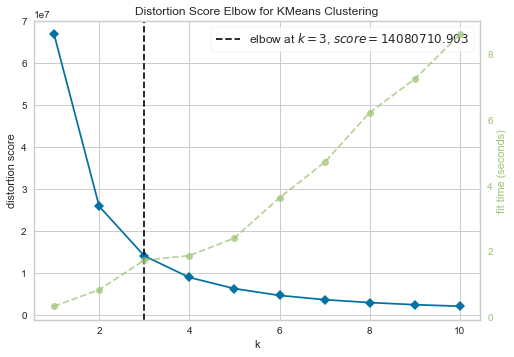

In [11]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(1,11))
visualizer.fit(atr)
visualizer.show()

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt

plt.figure(figsize=(4 * 4,  2 * 8))

scores = {}
best_kmeans = None
best_score = -1
for n_clusters in range(2, 4):
    plt.subplot(4, 2, n_clusters - 1)
    kmeans = KMeans(n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(atr)
    scores[n_clusters] = visualizer.silhouette_score_
    if visualizer.silhouette_score_ > best_score:
        best_score = visualizer.silhouette_score_
        best_kmeans = kmeans
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

KMeans clustering is implemented after deciding that the proper number of clusters is 3.

In [14]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=1)
kmeans.fit_predict(atr)
bi_df_2['cluster'] = kmeans.labels_  # clusters' labels added to the initial data set

In [15]:
print(bi_df_2.shape)
bi_df_2.head(5)

(162954, 3)


,times_ordered,total_amount,cluster
user_id,,,
27462,1,10.6,0
39238,2,35.0,1
41354,4,29.0,1
44068,1,19.5,0
49220,1,5.3,0


In [16]:
bi_df_2.cluster.value_counts()

0    114572
1     40481
2      7901
Name: cluster, dtype: int64

With a merge actions each customer will get assigned the group that belongs back into the intial dataset

In [17]:
final_dataset = pd.merge(bi_df, 
               bi_df_2[[ 'cluster']], 
               on='user_id',
               how='left')

print(final_dataset.shape)
final_dataset.head(5)

(400000, 9)


,order_id,brand,submit_dt,user_id,shop_id,city,cuisine_parent,basket,cluster
0,2846837765,GR-EFOOD,2021-01-13 20:37:06 UTC,99103596,206490318,Βόλος,Healthy / Other,9.0,1
1,2878146359,GR-EFOOD,2021-01-22 14:28:57 UTC,77179398,206490318,Βόλος,Healthy / Other,7.0,0
2,2904155390,GR-EFOOD,2021-01-29 13:52:24 UTC,7233822,206490318,Βόλος,Healthy / Other,6.3,1
3,2867086278,GR-EFOOD,2021-01-19 12:19:59 UTC,68621466,206490318,Βόλος,Healthy / Other,7.0,1
4,2875723043,GR-EFOOD,2021-01-21 20:08:59 UTC,17007258,206490318,Βόλος,Healthy / Other,11.8,0


That dataset will be exported in order to get used with PowerBI

In [26]:
final_dataset.to_excel('efood_PBI_data.xlsx')

Next actions will be held in Power BI